# Exercise 8 - Polynomial Kernels

In this exercise we will use the famous kernel trick with polynomial kernels to extend logistic regression to nonlinear decision boundaries.

In the event of a persistent problem, do not hesitate to contact the course instructor under

- paul.kahlmeyer@uni-jena.de
- maurice.wenig@uni-jena.de

### Submission
- Deadline of submission:
11.06.2024 23:59
- Submission on [moodle page](https://moodle.uni-jena.de/course/view.php?id=54249)

In [30]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import random
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from tqdm.notebook import tqdm as tqdm
from utils import plot_decision_boundary
from utils import LogisticRegressor
from tqdm import tqdm


# The Dataset

In this exercise we are using a toy [circle dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html#sklearn.datasets.make_circles) from scikit learn.

### Task 1
The dataset does not contain the column of ones to support affine transformations, extend it just as we did in Exercise 3. Moreover the labels in `y` are from $\{0,1\}$. Transform them so they come from $\{-1,1\}$, i.e. replaces all 0 with a -1. We will need this formulation in the next tasks.

Display the dataset using matplotlib, make sure to color the points according to their label.

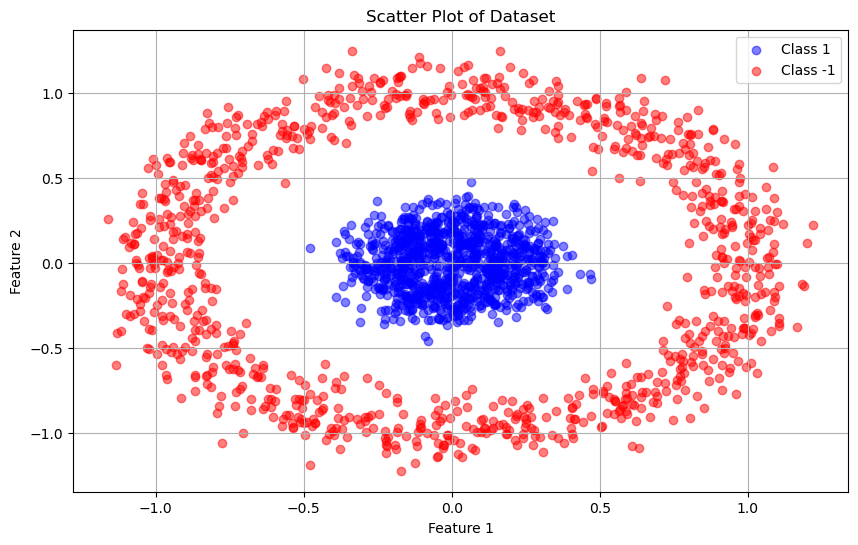

In [31]:
# TODO: Load + transform dataset
y = np.load('y.npy')
x = np.load('X.npy')
x = np.hstack([np.ones((x.shape[0], 1)), x])
y[y == 0] = -1

# assertions
assert x.shape == (2000, 3)
assert y.shape == (2000,)
assert np.count_nonzero(y == 1) == 1000
assert np.count_nonzero(y == -1) == 1000

# TODO: plot data set
plt.figure(figsize=(10, 6))
plt.scatter(x[y == 1, 1], x[y == 1, 2], color='blue', label='Class 1', alpha=0.5)
plt.scatter(x[y == -1, 1], x[y == -1, 2], color='red', label='Class -1', alpha=0.5)
plt.title('Scatter Plot of Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

## Logistic Regression

Each feature in this dataset has one of two possible labels. 
The standard approach for binary classification tasks is logistic regression.

### Task 2
Use scikit learn to fit logistic regression on the dataset. Use crossvalidation to assess the performance of the classificator.

In [32]:
# TODO: learn logistic classificator
regressor = LogisticRegression()
regressor.fit(x[:,[1,2]],y)
theta = np.hstack([regressor.intercept_, regressor.coef_.ravel()])
assert np.allclose(theta, [2.90668163e-05, 3.66405892e-03, -2.03939512e-02], atol=1e-2)


# TODO: assess performance with crossvalidation (10 folds)
cv_scores = cross_val_score(regressor, x, y, cv=10)
assert np.allclose(cv_scores, [0.48, 0.505, 0.5, 0.535, 0.475, 0.44, 0.46, 0.455, 0.43, 0.485], atol=1e-2)

### Task 3
Use `utils.plot_decision_boundary` to visualize the predictions made with logistic regression in order to get an understanding on the results. Why does logistic regression perform so bad?

[ 2.91085700e-05  3.66404208e-03 -2.03938714e-02]


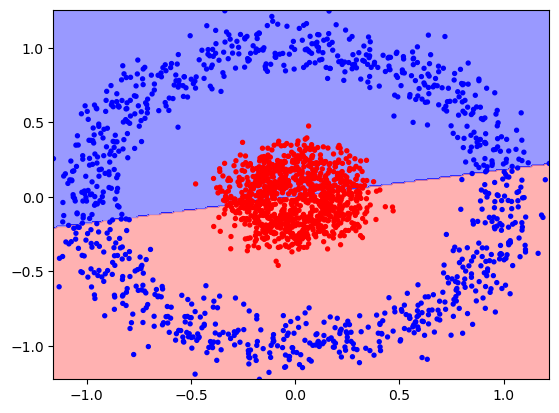

In [33]:
# TODO: visualize predictions using utils.plot_decision_boundary
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
print(theta)
plot_decision_boundary(x[:,[1,2]],y,regressor.predict)

# TODO: why is logistic regression bad here?

## Gradient


Last time we implemented a gradient descent solver for the logistic regression model ourself. For that we needed the gradient of the loss function. As we use a different labeling this time, we can take the vectorized loss function from the script, which reads as:

\begin{align*}
L(X, y, \theta) = \textsf{vec}(1)^\top \log \big(\textsf{vec}(1) + \exp ( -y \odot X \theta) \big)\,,
\end{align*}
where $\textsf{vec}(1)$ is the vector of ones and $\odot$ denotes elementwise multiplication.

Note that in the script we had to transpose $X$. Here it is already in that transposed from.


We can easily get a gradient for this using [Matrix Calculus](http://www.matrixcalculus.org/). In their notation and replacing $\theta$ with $w$ we get: 

`vector(1)'*log(vector(1)+exp(-y.*(X*w)))`

The tool allows you to download python code for calculating the function and its gradient at a given point in one step. 

### Task 4
Head over to the page, insert the function definition `vector(1)'*log(vector(1)+exp(-y.*(X*w)))` and download the code. Paste the relevant part into the function below.

In [34]:
def fAndG(X: npt.NDArray[np.float64], y: npt.NDArray[np.int8], w: npt.NDArray[np.float64]) -> tuple[float, npt.NDArray[np.float64]]:
    """Calculates loss and gradient of loss wrt. parameter vector.

    Parameters
    ----------
    X : npt.NDArray[np.float64]
        Features, shape (n_samples, n_features).
    y : npt.NDArray[np.int8]
        Labels, shape (n_samples,).
    w : npt.NDArray[np.float64]
        Parameter vector, shape (n_features,).

    Returns
    -------
    tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]
        Loss at w (scalar) and gradient of the loss wrt. w, shape (n_features,).
    """

    # TODO: Paste code from matrix calculus
    assert isinstance(X, np.ndarray)
    dim = X.shape
    assert len(dim) == 2
    X_rows = dim[0]
    X_cols = dim[1]
    assert isinstance(w, np.ndarray)
    dim = w.shape
    assert len(dim) == 1
    w_rows = dim[0]
    assert isinstance(y, np.ndarray)
    dim = y.shape
    assert len(dim) == 1
    y_rows = dim[0]
    assert X_rows == y_rows
    assert w_rows == X_cols

    t_0 = np.exp(-(y * (X).dot(w)))
    t_1 = (np.ones(X_rows) + t_0)
    functionValue = np.sum(np.log(t_1))
    gradient = -(X.T).dot(((t_0 * y) / t_1))

    return functionValue, gradient


# assertions
loss, gradient = fAndG(x, y, theta)
assert np.isclose(loss, 1386.2647726504017)
assert np.allclose(gradient, [0.00146652, -0.00292675, 0.01676499],atol=1e-2)

### Task 5

Now use this function to learn a logistic regression classifier. You find the necessary class in `utils.py`.

Plot the decision boundary and visualize the loss and accuracy over the training iterations.

[ 0.00368998 -0.0205117 ]


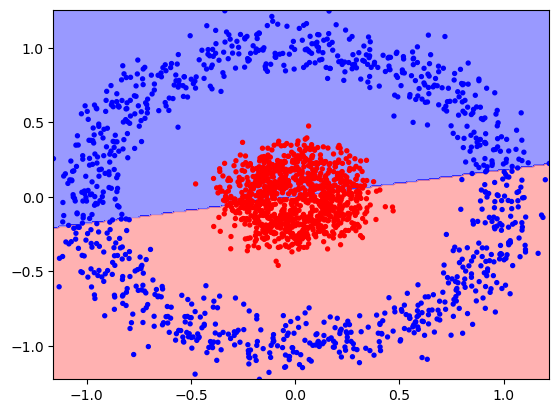

In [35]:
# TODO: fit LogReg
regressor = LogisticRegressor(fAndG,learn_rate=0.01,epsilon=1e-6,max_iterations=5000)


# TODO: plot accuracy, loss and decision boundary
regressor.fit(x[:,[1,2]],y)
print(regressor.theta)

plot_decision_boundary(x[:,[1,2]],y,regressor.predict)

## The Polynomial kernel

As you can see the result of our own implementation is very similar to the one provided by sklearn. However, for both of them we get bad results, as the linear decision boundary cannot separate the two classes.


This is where kernels and feature maps come in. Kernels and feature maps are functions, that map our features into a higher dimensional space, where they can be seperated by a linear regression line. 


<div>
<img src="images/feature_map.png" width="700"/>
</div>

A kernel is now a feature map, where we can **calculate the inner product of the higher dimensional feature vectors while staying in the original feature space**.

This is especially useful, since many machine learning algorithms use the inner product as a measure of similarity. Replacing the inner product with a kernel function will thus calculate the similarity in a higher dimension while saving computational effort.


A special kernel is the **Polynomial kernel**:

$$
k:\mathbb{R}^n\times\mathbb{R}^n \rightarrow \mathbb{R},\:
(x^{(1)},x^{(2)})\mapsto  \left( {x^{(1)}}^\top x^{(2)}\right)^d.
$$

(Note that as usual vectors are assumed to be column vectors, but observations in our $X$ are *row* vectors!)

This kernel takes two vectors $x^{1}$ and $x^{2}$ and calculates a number. 
It turns out that this number is exactly the inner product of the polynomial transformed vectors $\varphi_d(x^{(i)})$ that contain all products that can be created from $d$ components of $x^{(i)}$. 

In other words
\begin{align}
k(x^{(1)}, x^{(2)}) &= \left( {x^{(1)}}^\top x^{(2)}\right)^d\\
&= \varphi_d(x^{(1)})^T\varphi_d(x^{(2)})
\end{align}

Lets first convince ourselves that this is actually true.

### Task 6

Implement the polynomial transformation $\varphi_d(x)$, which creates a vector containing all products of $d$ components for a given $x$.

For example for $x = [x_1, x_2]^T$ and $d=2$ we would transform the vector $x$ like
\begin{align*}
\varphi_2(x) &= \begin{bmatrix}
x_1^2\\
x_1x_2\\
x_2x_1\\
x_2^2
\end{bmatrix}
\end{align*}
The order of the entries does not matter.

In [36]:
import itertools
from collections import Counter


def phi(x: npt.NDArray[np.float64], d: int) -> npt.NDArray[np.float64]:
    """Creates a vector containing all monomials of degree d from x.

    Parameters
    ----------
    x : npt.NDArray[np.float64]
        Vector of shape (n_features,).
    d : int
        Degree of the monomials to create.

    Returns
    -------
    npt.NDArray[np.float64]
        A vector of shape (n_features^d,) containing all monomials of degree d.
    """

    # TODO: implement
    temp_id = list(np.arange(0, x.shape[0], 1))
    temp_list = [temp_id] * d
    combinations = itertools.product(*temp_list)
    res = []
    for combination in combinations:
        res.append(np.prod([x[i] for i in combination]))
    return np.array(res)


test_input = np.array([2, 3, 5])
test_result = phi(test_input, 3)
assert test_result.shape == (27,)
assert Counter(test_result) == Counter([8, 12, 20, 12, 18, 30, 20, 30, 50, 12, 18, 30, 18, 27, 45, 30, 45, 75, 20, 30, 50, 30, 45, 75, 50, 75, 125])

### Task 7
Now perform a small experiment for a polynomial degree $d = 5$ and $k = 5$ dimensional vectors:

1. Draw two random vectors $x_1, x_2\in\mathbb{R}^k$
2. Calculate the dot product $\varphi_p(x_1)^T\varphi_p(x_2)$
3. Calculate $(x_1^Tx_2)^d$
4. Compare the results

Repeat this experiment 100 times and report the average times for calculating both results.

In [39]:
# TODO: Perform experiment
from timeit import default_timer as timer
n_features = 2
degree = 5
n_samples = 100
X1 = np.random.rand(n_samples,n_features)
X2 = np.random.rand(n_samples,n_features) 

X1_poly = np.stack([phi(x, degree) for x in X1])
X2_poly = np.stack([phi(x, degree) for x in X2])

avg_poly = 0
avg_kernel = 0

for i in range(100):
    start_time = timer()
    result1 = X1_poly[i] @ X2_poly[i].T
    end_time = timer()
    avg_poly += end_time - start_time
    
    start_time = timer()
    result2 = (X1[i] @ X2[i].T) ** degree
    end_time = timer()
    avg_kernel += end_time

    assert np.isclose(result1, result2)
    
avg_poly /= 100
avg_kernel /= 100

## Rewriting the Loss

An immediate consequence of the representer theorem (see lecture notes) is that we can
optimize over $a\in\mathbb{R}^m$ instead of $\theta\in\mathbb{R}^n$,
namely by substituting $\theta=X a$ in the original optimization
problem, which results in an equivalent *adjoint* formulation:

$$
\hat a \,=\, \text{argmin}_{a\in\mathbb{R}^m} \: L(XX^\top a, y) + c\cdot a^\top XX^\top a
$$

(note in contrast to above we added some regularization here)

The so called *kernel trick* just means replacing the Gram matrix $X X^\top$ by
the kernel matrix

$$
K \,=\, \Big( k(x^{(i)},x^{(j)}) \Big)_{i,j\in [m]} = \left(\left( {x^{(i)}}^\top x^{(j)}\right)^d\right)_{i,j\in [m]}.
$$

After this
replacement, the adjoint problem reads as:

\begin{align*}
\hat a \,&=\text{argmin}_{a\in\mathbb{R}^m}\: L(Ka, y) + c\cdot a^\top Ka  \\
 &=\text{argmin}_{a\in\mathbb{R}^m}\: \textsf{vec}(1)^\top\log(\mathrm{vector}(1)+\exp((-y)\odot (K\cdot a)))+c\cdot a^\top \cdot K\cdot a 
\end{align*}

We will now implement the kernel matrix, a predict function, derive a gradient for the new loss function and solve the adjoint problem with the Kernel matrix using an adjusted gradient descent.

### Task 8

Implement a function that takes to two matrices $X_1$, $X_2$ and the degree of the polynom $d$. It should return their polynomial kernel matrix $K$ of degree $d$. We will need this more generalized setting for the prediction in the next task.

In [41]:
def poly_kernel(x_1: npt.NDArray[np.float64], x_2: npt.NDArray[np.float64], d: int) -> npt.NDArray[np.float64]:
    """Calculates the polyonomial kernel matrix.

    Parameters
    ----------
    x_1 : npt.NDArray[np.float64]
        Sample matrix, shape (m_1, d).
    x_2 : npt.NDArray[np.float64]
        Sample matrix, shape (m_2, d).
    d : int
        Polynomial degree.

    Returns
    -------
    npt.NDArray[np.float64]
        Kernel matrix, shape (m_1, m_2).
    """

    # TODO: implement
    return (x_1 @ x_2.T) ** d


# assertions
sample_matrix = np.arange(12).reshape(4, 3)
expected_result = np.array([[25, 196, 529, 1024],
                            [196, 2500, 7396, 14884],
                            [529, 7396, 22201, 44944],
                            [1024, 14884, 44944, 91204]])
assert np.allclose(poly_kernel(sample_matrix, sample_matrix, 2), expected_result)

## Rewriting the predictor 

Calculating the probabilities we can also substitute $\theta$ with $Xa$:

\begin{align*}
p(Y = 1|x) &= \sigma(-\theta^Tx)\\
&= \sigma(-(Xa)^Tx)\\
&= \sigma(-a^T X^Tx)\\
&= \sigma\left(-\sum_{i=1}^m a_i\, k\left(x,x^{(i)}\right)\right)\\
\end{align*}


### Task 9
If we look at $\sum_{i=1}^m a_i\, k(x,x^{(i)})$, we see that this is a scalar product between a and the vector $(k(x,x^{(i)}))_{i\in [m]}$, which we can create with `kernel(x,X)`. In fact we can replace the single vector `x` with a stack of $p$ vectors (i.e. a matrix) and multiply that with $a$ to get several values for predictions with one operation. Therefore, implement a new `get_probs` function that takes such a matix $K\in \mathbb{R}^{p\times m}$ (which was generated by `kernel`) and an estimated $a$ and returns the predicted probabilities.

In [43]:
from typing import Callable


def get_probs(kernel_func: Callable[[npt.NDArray[np.float64], npt.NDArray[np.float64]], npt.NDArray[np.float64]], a: npt.NDArray[np.float64], x: npt.NDArray[np.float64], x_pred: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    """Calculates the probability of y=1 for each sample in x_pred.

    Parameters
    ----------
    kernel_func : Callable[[npt.NDArray[np.float64], npt.NDArray[np.float64]], npt.NDArray[np.float64]]
        Function that takes two sample matrices and calculates the kernel matrix.
    a : npt.NDArray[np.float64]
        Parameter vector in representer theorem, shape (n_samples,).
    x : npt.NDArray[np.float64]
        Training sample matrix, shape (n_samples, n_features).
    x_pred : npt.NDArray[np.float64]
        Predicted sample matrix, shape (n_samples_pred, n_features).

    Returns
    -------
    npt.NDArray[np.float64]
        Vector of probabilities for each sample in x_pred, shape (n_samples_pred,).
    """

    # TODO: implement
    K = kernel_func(x_pred, x)
    temp = K @ a
    return 1 / (1 + np.exp(-temp))


# assertions
np.random.seed(0)
x_small = x[:4]
test_a = (np.random.rand(len(x_small)) * 2 - 1) * .01
kernel_func = lambda X1, X2: poly_kernel(X1, X2, 2)
p = get_probs(kernel_func, test_a, x_small, x_small)
assert np.allclose(p, np.array([0.50243682, 0.5020485, 0.50204518, 0.50205951]))

### Task 10

As mentioned above the new objective function reads as:

$$\textsf{vec}(1)^\top\log(\mathrm{vector}(1)+\exp((-y)\odot (K\cdot a)))+c\cdot a^\top \cdot K\cdot a$$

Head over to [Matrix Calculus](http://www.matrixcalculus.org/) and transform the function to match their notation. Download the python code and copy the relevant function to this notebook below.

Make sure the provided assertions pass.

In [50]:

def fAndG_poly(K: npt.NDArray[np.float64], a: npt.NDArray[np.float64], c: float, y: npt.NDArray[np.int8]) -> tuple[float, npt.NDArray[np.float64]]:
    """Calculates loss and gradient of loss wrt. parameter vector.

    Parameters
    ----------
    kernel_matrix : npt.NDArray[np.float64]
        Kernel matrix, shape (n_samples, n_samples).
    a : npt.NDArray[np.float64]
        Parameter vector in representer theorem, shape (n_samples,).
    c : float
        Regularization parameter.
    y : npt.NDArray[np.int8]
        Labels, shape (n_samples,).

    Returns
    -------
    tuple[float, npt.NDArray[np.float64]]
        Loss at a (scalar) and gradient of the loss wrt. a, shape (n_samples,).
    """

    # TODO: copy & paste function body from downloaded code
    assert isinstance(K, np.ndarray)
    dim = K.shape
    assert len(dim) == 2
    K_rows = dim[0]
    K_cols = dim[1]
    if isinstance(c, np.ndarray):
        dim = c.shape
        assert dim == (1, )
    assert isinstance(a, np.ndarray)
    dim = a.shape
    assert len(dim) == 1
    a_rows = dim[0]
    assert isinstance(y, np.ndarray)
    dim = y.shape
    assert len(dim) == 1
    y_rows = dim[0]
    assert a_rows == K_rows == y_rows
    assert a_rows == K_cols == K_rows
    assert a_rows == y_rows == K_cols == K_rows

    t_0 = (K).dot(a)
    t_1 = np.exp(-(y * t_0))
    t_2 = (np.ones(a_rows) + t_1)
    functionValue = (np.sum(np.log(t_2)) + (c * (a).dot(t_0)))
    gradient = (((c * t_0) - (K.T).dot(((t_1 * y) / t_2))) + (c * (K.T).dot(a)))

    return functionValue, gradient



# assertions
test_kernel_matrix = np.array([[3.7844177012259865, 0.7891196584397753, 0.9029368253328784],
                          [0.7891196584397753, 1.0456359627092107, 0.9634124453522385],
                          [0.9029368253328784, 0.9634124453522385, 1.136054990935599]])
test_a = np.array([0.36550651, 0.2750498, 0.57661826])
test_c = 0.001
test_y = np.array([-1, 1, 1])
loss, gradient = fAndG_poly(test_kernel_matrix, test_a, test_c, test_y)
assert np.isclose(loss, 2.7674497328693235, 0.001)
assert np.allclose(gradient, np.array([2.989908913027514, 0.2373421163827483, 0.3208161644797845]))

### Task 11

Now lets put everything together. Below you find a class similar to the `LogisticRegressor` class.

Adapt the class to support polynomial kernels. 

Learn a logistic regressor with a polynomial kernel of degree 2 on the dataset, visualize the loss and accuracy over the training iterations and plot the decision boundary.

Note: If the flag `used_cached_kernel` is set, we want to predict the probabilities on the training data. Then we can use the Kernel matrix $K$ for the training data that we already calculated during fitting the model. This way we need to calculate $K$ only once during training.

In [53]:
from sklearn.base import BaseEstimator
from typing import Self


def sigmoid(x: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    """Sigmoid function.

    Parameters
    ----------
    x : npt.NDArray[np.float64]
        Array of any dimension with scalar entries.

    Returns
    -------
    npt.NDArray[np.float64]
        Array of the same shape as the input with the sigmoid function applied element-wise.
    """

    return 1 / (1 + np.exp(-x))


class PolynomialLogisticRegressor(BaseEstimator):
    def __init__(self, compute_loss_and_gradient: Callable[[npt.NDArray[np.float64], npt.NDArray[np.float64], float, npt.NDArray[np.int8]], tuple[float, npt.NDArray[np.float64]]], degree: int, regularization_parameter: float = 1e-2, learn_rate: float = 1e-5, max_iterations: int = 10_000, epsilon: float = 1e-1):
        """Regressor for binary classification using logistic regression with a polynomial kernel. Fits using gradient descent.

        Parameters
        ----------
        compute_loss_and_gradient : Callable[[npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.int8]], tuple[float, npt.NDArray[np.float64]]]
            Function that computes the loss and gradient for the given the kernel, parameters, regularization constant, and labels (in {-1, 1}) (in that order).
        regularization_parameter : float, optional
            Regularization parameter, by default 1e-2.
        learn_rate : float, optional
            Learning rate, sets step size for descent, by default 1e-2.
        max_iterations : int, optional
            Maximum number of descent steps, by default 1000.
        epsilon : float, optional
            Descent stops early if the loss did not change more than this, by default 1e-5.
        """

        self.compute_loss_and_gradient = compute_loss_and_gradient
        self.degree = degree
        self.regularization_parameter = regularization_parameter
        self.learn_rate = learn_rate
        self.max_iterations = max_iterations
        self.epsilon = epsilon
        self.a: npt.NDArray[np.float64] = None
        self.training_x: npt.NDArray[np.float64] = None
        self.kernel_matrix: npt.NDArray[np.float64] = None
        self.accuracies = []
        self.losses = []

    def score(self, x: npt.NDArray[np.float64], y: npt.NDArray[np.float64], used_cached_kernel: bool = False) -> float:
        """Calculates the accuracy of the model on the given data.

        Parameters
        ----------
        x : npt.NDArray[np.float64]
            Matrix with datapoints as rows (m x n).
        y : npt.NDArray[np.float64]
            Vector of true labels (m), entries in {-1, 1}.
        used_cached_kernel : bool, optional
            If True, uses the cached kernel self.kernel_matrix matrix, by default False.

        Returns
        -------
        float
            Accuracy of the model.
        """

        return np.mean(self.predict(x, used_cached_kernel) == y)

    def predict(self, x: npt.NDArray[np.float64], used_cached_kernel: bool = False) -> npt.NDArray[np.float64]:
        """Predicts labels y given features x and learned parameters theta.

        Parameters
        ----------
        x : npt.NDArray[np.float64]
            Matrix with datapoints as rows (m x n).
        used_cached_kernel : bool, optional
            If True, uses the cached kernel self.kernel_matrix matrix, by default False.

        Returns
        -------
        npt.NDArray[np.float64]
            Array of predictions (m), entries in {-1, 1}.
        """

        probabilities = self.probability(x, used_cached_kernel)
        return 2 * np.round(probabilities) - 1

    def probability(self, x: npt.NDArray[np.float64], used_cached_kernel: bool = False) -> npt.NDArray[np.float64]:
        """Predicts probabilities of y=1 given features x and learned parameters theta.

        Parameters
        ----------
        x : npt.NDArray[np.float64]
            Matrix with datapoints as rows (m x n).
        used_cached_kernel : bool, optional
            If True, uses the cached kernel self.kernel_matrix matrix, by default False.

        Returns
        -------
        npt.NDArray[np.float64]
            Array of probabilities (m), entries in [0, 1].
        """

        # TODO: implement
        pass

    def fit(self, x: npt.NDArray[np.float64], y: npt.NDArray[np.float64]) -> Self:
        """Gradient descent for binary crossentropy. Starts at a random parameter vector and tracks losses and accuracies along the iterations.

        Parameters
        ----------
        x : npt.NDArray[np.float64]
            Matrix with datapoints as rows (m x n).
        y : npt.NDArray[np.float64]
            Vector of true labels (m), entries in {-1, 1}.
        """

        # TODO: implement
        pass


# TODO: use and fit class

# TODO: plot accuracy, loss and decision boundary

### Task 12

Use a 10 fold crossvalidation to evaluate the performance of the `LogRegPoly` class.

In [55]:
# TODO: assess performance with crossvalidation (10 folds)
cv_scores = cross_val_score(clf, x[:,[1,2]], y, cv=10)
print(cv_scores)

NameError: name 'clf' is not defined